In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
sns.set_theme(style='whitegrid')

In [2]:
bristol_schools = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Cleaning/cleaned-data/bristol_schools_cleaned.csv")
cornwall_schools = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Cleaning/cleaned-data/cornwall_schools_cleaned.csv")

In [3]:
bristol_crime = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Cleaning/cleaned-data/bristol-crime-cleaned.csv")
cornwall_crime = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Cleaning/cleaned-data/cornwall-crime-cleaned.csv")

In [4]:
popn_2011 = pd.read_csv("/Users/anukul/Desktop/Anukul/Learning/DataScience/Obtaining/population-2011.csv")

In [5]:
popn_2011['Population'] = popn_2011['Population'].str.replace(',', '').astype(float)

In [6]:
population_2022 = popn_2011.copy()
population_2022['Population_2022'] = population_2022['Population'] * (1.00561255390388033 ** (2022 - 2011))

In [8]:
bristol_crime['Postcode'] = bristol_crime['postcode'].str.extract(r'^(\S+ \d)')
bristol_crime['Year'] = bristol_crime['Year'].astype(str).str[:4]

cornwall_crime['Postcode'] = cornwall_crime['postcode'].str.extract(r'^(\S+ \d)')
cornwall_crime['Year'] = cornwall_crime['Year'].astype(str).str[:4]

In [10]:
bristol_drug_rates = (bristol_crime
                      .query('Year == "2022" and Crime_type == "Drugs"')
                      .merge(population_2022[['Postcode', 'Population_2022']], on='Postcode', how='left')
                      .dropna(subset=['Population_2022'])
                      .groupby('Postcode')
                      .agg(Drug_Offenses=('Crime_type', 'size'),
                           Population=('Population_2022', 'first'))
                      .reset_index()
                      .assign(Drug_Offense_Rate=lambda x: x['Drug_Offenses'] / x['Population'] * 10000))

In [11]:
cornwall_drug_rates = (cornwall_crime
                       .query('Year == "2022" and Crime_type == "Drugs"')
                       .merge(population_2022[['Postcode', 'Population_2022']], on='Postcode', how='left')
                       .dropna(subset=['Population_2022'])
                       .groupby('Postcode')
                       .agg(Drug_Offenses=('Crime_type', 'size'),
                            Population=('Population_2022', 'first'))
                       .reset_index()
                       .assign(Drug_Offense_Rate=lambda x: x['Drug_Offenses'] / x['Population'] * 10000))

In [12]:
bristol_schools['Postcode'] = bristol_schools['Postcode'].str.extract(r'^(\S+ \d)')
bristol_schools = bristol_schools.query('Year == 2022')[['Postcode', 'ATT8SCR']]

In [14]:
cornwall_schools['Postcode'] = cornwall_schools['Postcode'].str.extract(r'^(\S+ \d)')
cornwall_schools = cornwall_schools.query('Year == 2022')[['Postcode', 'ATT8SCR']]

In [15]:
bristol_analysis = (bristol_schools
                    .merge(bristol_drug_rates, on='Postcode')
                    .rename(columns={'ATT8SCR': 'Attainment_8_Score', 'Drug_Offense_Rate': 'Drug_Offense_Rate'}))

In [17]:
bristol_analysis.head()

,Postcode,Attainment_8_Score,Drug_Offenses,Population,Drug_Offense_Rate
0,BS13 7,40.6,17,8844.067138,19.221926
1,BS13 8,SUPP,28,7805.027504,35.874313
2,BS10 7,43.3,14,8382.508078,16.701445
3,BS16 4,NE,10,9763.994756,10.241710
4,BS13 0,35.8,28,8020.918032,34.908722


Removing rows with N/A values or even non numeric

In [21]:
bristol_analysis['Attainment_8_Score'] = pd.to_numeric(bristol_analysis['Attainment_8_Score'], errors='coerce')
bristol_analysis['Drug_Offense_Rate'] = pd.to_numeric(bristol_analysis['Drug_Offense_Rate'], errors='coerce')
bristol_analysis = bristol_analysis.dropna(subset=['Attainment_8_Score', 'Drug_Offense_Rate'])

Linear Modelling for bristol : 

In [22]:
x_bristol = bristol_analysis[['Attainment_8_Score']]
y_bristol = bristol_analysis['Drug_Offense_Rate']
model_bristol = LinearRegression().fit(x_bristol, y_bristol)
predictions_bristol = model_bristol.predict(x_bristol)
r2_bristol = r2_score(y_bristol, predictions_bristol)
print(f"R-squared (Bristol): {r2_bristol}")

R-squared (Bristol): 0.00688145083634395


In [25]:
X_bristol_sm = sm.add_constant(bristol_analysis[['Attainment_8_Score']])
y_bristol_sm = bristol_analysis['Drug_Offense_Rate']

model_bristol_sm = sm.OLS(y_bristol_sm, X_bristol_sm).fit()
print("Model Summary (Bristol):")
print(model_bristol_sm.summary())

Model Summary (Bristol):
                            OLS Regression Results                            
Dep. Variable:      Drug_Offense_Rate   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.092
Method:                 Least Squares   F-statistic:                   0.06929
Date:                Mon, 19 Aug 2024   Prob (F-statistic):              0.798
Time:                        20:30:59   Log-Likelihood:                -43.261
No. Observations:                  12   AIC:                             90.52
Df Residuals:                      10   BIC:                             91.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


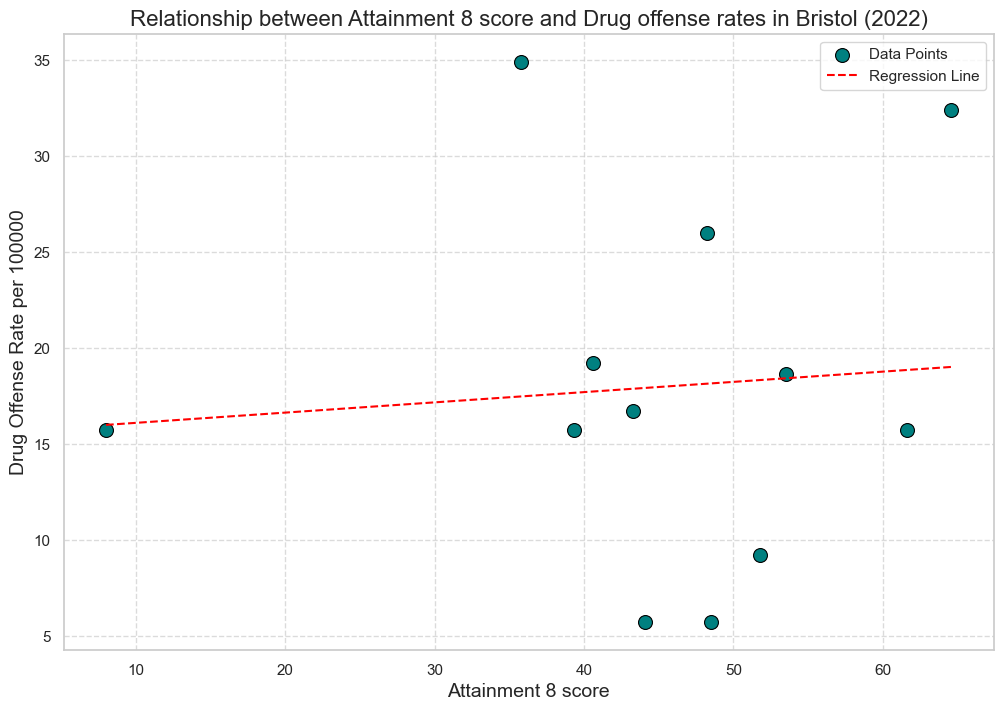

In [38]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=bristol_analysis, x='Attainment_8_Score', y='Drug_Offense_Rate', color='teal', label='Data Points', s=100, edgecolor='black')
sns.lineplot(data=bristol_analysis, x='Attainment_8_Score', y=predictions_bristol, color='red', linestyle='--', label='Regression Line')
plt.title('Relationship between Attainment 8 score and Drug offense rates in Bristol (2022)', fontsize=16)
plt.xlabel('Attainment 8 score', fontsize=14)
plt.ylabel('Drug Offense Rate per 100000', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Following same steps for Cornwall

In [27]:
cornwall_analysis = (cornwall_schools
                     .merge(cornwall_drug_rates, on='Postcode')
                     .rename(columns={'ATT8SCR': 'Attainment_8_Score', 'Drug_Offense_Rate': 'Drug_Offense_Rate'}))

In [29]:
cornwall_analysis['Attainment_8_Score'] = pd.to_numeric(cornwall_analysis['Attainment_8_Score'], errors='coerce')
cornwall_analysis['Drug_Offense_Rate'] = pd.to_numeric(cornwall_analysis['Drug_Offense_Rate'], errors='coerce')
cornwall_analysis = cornwall_analysis.dropna(subset=['Attainment_8_Score', 'Drug_Offense_Rate'])

In [30]:
X_cornwall = cornwall_analysis[['Attainment_8_Score']]
y_cornwall = cornwall_analysis['Drug_Offense_Rate']
model_cornwall = LinearRegression().fit(X_cornwall, y_cornwall)
predictions_cornwall = model_cornwall.predict(X_cornwall)
r2_cornwall = r2_score(y_cornwall, predictions_cornwall)
print(f"R-squared (Cornwall): {r2_cornwall}")

R-squared (Cornwall): 0.0011498694938499865


In [32]:
X_cornwall_sm = sm.add_constant(cornwall_analysis[['Attainment_8_Score']])
y_cornwall_sm = cornwall_analysis['Drug_Offense_Rate']

model_bristol_sm = sm.OLS(y_cornwall_sm, X_cornwall_sm).fit()
print("Model Summary (Bristol):")
print(model_bristol_sm.summary())

Model Summary (Bristol):
                            OLS Regression Results                            
Dep. Variable:      Drug_Offense_Rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                   0.02763
Date:                Mon, 19 Aug 2024   Prob (F-statistic):              0.869
Time:                        20:34:44   Log-Likelihood:                -108.37
No. Observations:                  26   AIC:                             220.7
Df Residuals:                      24   BIC:                             223.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

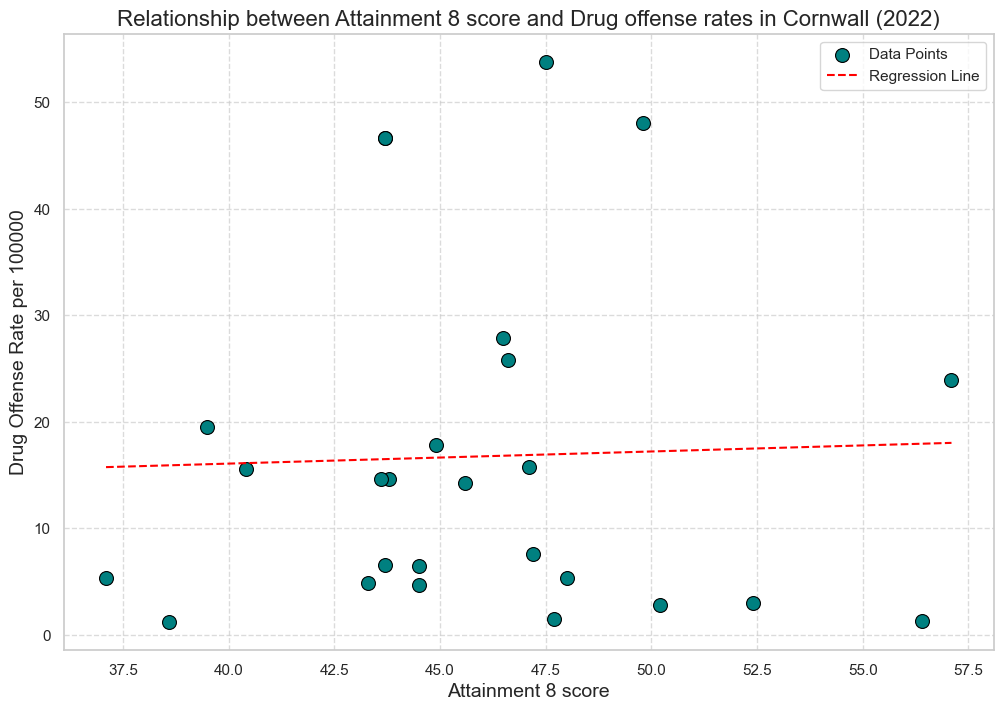

In [37]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cornwall_analysis, x='Attainment_8_Score', y='Drug_Offense_Rate', color='teal', label='Data Points', s=100, edgecolor='black')
sns.lineplot(data=cornwall_analysis, x='Attainment_8_Score', y=predictions_cornwall, color='red', linestyle='--', label='Regression Line')
plt.title('Relationship between Attainment 8 score and Drug offense rates in Cornwall (2022)', fontsize=16)
plt.xlabel('Attainment 8 score', fontsize=14)
plt.ylabel('Drug Offense Rate per 100000', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()